# Import necessary dependencies and settings

In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_colwidth = 200

# Sample corpus of text documents

In [2]:
corpus = [
    'The sky is blue and beautiful.',
    'Love this blue and beautiful sky!',
    'The quick brown fox jumps over the lazy dog.',
    "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
    'I love green eggs, ham, sausages and bacon!',
    'The brown fox is quick and the blue dog is lazy!',
    'The sky is very blue and the sky is very beautiful today',
    'The dog is lazy but the brown fox is quick!'
]

labels = ['weather', 'weather', 'animals', 'food',
          'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


# Simple text pre-processing

In [3]:
nltk.download('stopwords')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
  ## Lower case and remove special characters / whitespaces
  doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
  doc = doc.lower()
  doc = doc.strip()
  ## Tokenize document
  tokens = wpt.tokenize(doc)
  ## Filter stopwords out of document
  filtered_tokens = [token for token in tokens if token 
                     not in stop_words]
  ## Re-create document from filtered tokens
  doc = ' '.join(filtered_tokens)
  return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

# Word Embeddings

## Load up sample corpus - Bible

In [5]:
nltk.download('gutenberg')
nltk.download('punkt')

from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '01234566789'

norm_bible = [[word.lower() for word in sent if word 
               not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible 
              if len(tok_sent.split()) > 2]

print('Total lines: ', len(bible))
print('\nSample line: ', bible[10])
print('\nProcessed line: ', norm_bible[10])

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Total lines:  30103

Sample line:  ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line:  god said let firmament midst waters let divide waters waters


## Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture

### Build Vocabulary

In [6]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)]
        for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size: ', vocab_size)
print('Vocabulary Sample: ', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size:  12425
Vocabulary Sample:  [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


### Build (context_words, target_word) pair generator

In [0]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
  context_length = window_size * 2
  for words in corpus:
    sentence_length = len(words)
    for index, word in enumerate(words):
      context_words = []
      label_word = []
      start = index - window_size
      end = index + window_size + 1
      
      context_words.append([words[i]
                            for i in range(start, end)
                            if 0 <= i < sentence_length
                            and i != index])
      label_word.append(word)
      
      x = sequence.pad_sequences(context_words, 
                                 maxlen = context_length)
      y = np_utils.to_categorical(label_word, vocab_size)
      
      yield(x, y)

In [8]:
i = 0

for x, y in generate_context_word_pairs(corpus = wids,
                                        window_size = window_size,
                                        vocab_size = vocab_size):
  if 0 not in x[0]:
    print('Context (X): ', [id2word[w] for w in x[0]],
          '-> Target (Y): ', id2word[np.argwhere(y[0])[0][0]])
    
    if i == 10:
      break
    i += 1

Context (X):  ['old', 'testament', 'james', 'bible'] -> Target (Y):  king
Context (X):  ['first', 'book', 'called', 'genesis'] -> Target (Y):  moses
Context (X):  ['beginning', 'god', 'heaven', 'earth'] -> Target (Y):  created
Context (X):  ['earth', 'without', 'void', 'darkness'] -> Target (Y):  form
Context (X):  ['without', 'form', 'darkness', 'upon'] -> Target (Y):  void
Context (X):  ['form', 'void', 'upon', 'face'] -> Target (Y):  darkness
Context (X):  ['void', 'darkness', 'face', 'deep'] -> Target (Y):  upon
Context (X):  ['spirit', 'god', 'upon', 'face'] -> Target (Y):  moved
Context (X):  ['god', 'moved', 'face', 'waters'] -> Target (Y):  upon
Context (X):  ['god', 'said', 'light', 'light'] -> Target (Y):  let
Context (X):  ['god', 'saw', 'good', 'god'] -> Target (Y):  light


### Build CBOW Deep Network Model

In [9]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim = vocab_size,
                   output_dim = embed_size,
                   input_length = window_size * 2))
cbow.add(Lambda(lambda x: K.mean(x, axis = 1),
                output_shape = (embed_size, )))
cbow.add(Dense(vocab_size, activation = 'softmax'))


cbow.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop')
print(cbow.summary())






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


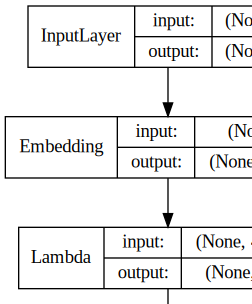

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes = True,
                 show_layer_names = False,
                 rankdir = 'TB').create(prog = 'dot',
                                        format = 'svg'))

### Train the model for 5 epochs

In [0]:
for epoch in range(1, 6):
  loss = 0.
  i = 0
  for x, y in generate_context_word_pairs(corpus = wids,
                                          window_size = window_size,
                                          vocab_size = vocab_size):
    i += 1
    loss += cbow.train_on_batch(x, y)
    if i % 100000 == 0:
      print('Processed {} (context, word) pairs'.format(i))
      print('Epoch: ', epoch, '\tLoss: ', loss)
      print()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Processed 100000 (context, word) pairs
Epoch:  1 	Loss:  849368.0256828042

Processed 200000 (context, word) pairs
Epoch:  1 	Loss:  1909949.1464607462

Processed 300000 (context, word) pairs
Epoch:  1 	Loss:  3095217.794131541

Processed 100000 (context, word) pairs
Epoch:  2 	Loss:  1059910.9278861494

Processed 200000 (context, word) pairs
Epoch:  2 	Loss:  2220453.413596831

Processed 300000 (context, word) pairs
Epoch:  2 	Loss:  3352706.64121494

Processed 100000 (context, word) pairs
Epoch:  3 	Loss:  1048647.829167318

Processed 200000 (context, word) pairs
Epoch:  3 	Loss:  2193169.723934218

Processed 300000 (context, word) pairs
Epoch:  3 	Loss:  3318162.291198939

Processed 100000 (context, word) pairs
Epoch:  4 	Loss:  1037030.6349849325

Processed 200000 (context, word) pairs
Epoch:  4 	Loss:  2165927.347717893

Processed 300000 (context, word) pairs
Epoch:  4 	Loss:  3289827.57

### Get word embeddings

In [11]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index = list(id2word.values())[1:]).head()


(12424, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
unto,0.047213,-0.041503,0.021190,-0.016963,0.047448,0.033092,-0.003252,0.037709,-0.009333,-0.027345,-0.011236,-0.041786,-0.001946,0.012325,-0.047853,0.032111,-0.016324,0.027005,-0.007731,0.045772,-0.004333,-0.015743,0.014902,-0.040998,0.019687,0.037372,-0.020794,-0.032140,-0.037990,-0.023804,-0.011451,-0.015227,-0.016807,-0.040840,-0.014582,0.046420,-0.039704,-0.027242,-0.001689,-0.048506,...,0.023087,0.035462,0.040738,-0.025128,0.039645,-0.002440,0.010932,-0.025146,0.012920,0.001402,0.036073,-0.021055,-0.047044,0.038967,-0.043327,-0.021617,-0.007198,-0.040649,0.001348,-0.048912,0.017109,-0.013556,0.042112,0.037753,0.029126,-0.040321,0.043760,-0.029848,-0.003470,-0.003118,-0.019737,-0.006301,-0.005327,-0.007286,-0.007267,-0.025835,0.028632,0.015768,0.010295,0.013058
lord,-0.013642,-0.023517,0.030979,0.009780,-0.004587,-0.029294,-0.046183,-0.032933,0.017229,0.041474,0.048838,0.047793,-0.019977,0.047996,-0.020838,-0.000532,0.019453,0.033843,0.013005,0.031206,-0.027470,-0.044514,0.041074,0.008953,0.046106,-0.005454,0.022575,-0.014482,-0.004054,-0.003900,-0.026071,0.027304,-0.038518,0.042153,0.022006,0.030486,0.026686,-0.004533,-0.012960,0.021443,...,-0.006019,0.028421,0.045901,0.041793,-0.029490,0.000406,0.007655,0.024028,0.038061,-0.049510,0.030684,0.023762,0.033957,0.005343,-0.023306,-0.024810,-0.019758,-0.026539,0.027206,-0.032767,-0.008838,-0.026491,-0.032189,-0.035655,-0.015328,0.003405,0.018761,-0.024560,-0.027715,0.042709,-0.004914,-0.005311,0.046187,0.023186,-0.029983,0.025834,0.000340,0.037972,-0.006711,0.034495
thou,-0.010239,0.035556,-0.012265,0.029930,0.029707,0.019882,0.008484,0.039340,0.023442,-0.047135,-0.044835,-0.017394,0.029777,0.037364,-0.003211,-0.039645,0.014361,0.023849,0.048220,-0.043311,0.037536,-0.019262,0.032006,-0.021661,-0.010263,0.045643,0.009150,0.015534,-0.028725,-0.003710,0.010516,0.039896,0.046970,0.035466,-0.043357,-0.024457,-0.021187,0.041041,0.040133,0.003278,...,0.035578,-0.024978,0.036755,-0.030556,-0.033254,0.004959,-0.034321,0.039374,0.044894,0.014310,0.041672,-0.040729,0.035001,-0.035349,0.043139,-0.043520,0.031251,-0.000543,0.049492,0.046491,-0.047000,-0.046346,-0.000464,-0.033547,0.029284,-0.033223,-0.031411,-0.004576,0.010587,-0.024816,0.034260,0.020089,0.037647,-0.014125,-0.015594,-0.011936,-0.044185,0.019834,0.029383,0.032377
thy,0.005640,0.026558,-0.006451,-0.020214,0.006661,-0.048893,-0.039559,0.016362,0.017160,-0.038332,0.011085,-0.008523,0.007492,0.036239,-0.024622,0.028199,-0.049667,0.029211,-0.013453,0.009298,-0.036485,0.014723,0.048056,0.039119,-0.045288,-0.016694,0.045302,0.013353,0.021442,0.017495,-0.016962,-0.043303,0.028512,0.036344,-0.033389,0.033688,0.029463,0.002182,-0.010471,-0.049943,...,-0.027445,0.048329,0.042973,0.014407,0.015924,0.032941,-0.048548,-0.007488,-0.038039,-0.016687,0.005895,0.037431,0.039987,0.031230,0.016698,-0.016183,0.018574,-0.044364,-0.013606,-0.018880,0.040530,-0.004375,0.027513,-0.022276,-0.040510,0.025159,0.034912,-0.009173,0.023612,-0.039242,-0.023503,0.017839,-0.038867,-0.022981,-0.045870,0.028763,-0.018592,0.017746,-0.029748,-0.001045
god,-0.000685,-0.004262,-0.048669,-0.004590,-0.034123,0.047712,-0.022369,0.014993,0.042666,0.008680,-0.040384,-0.011804,-0.003933,0.009052,0.006012,-0.037091,-0.002712,-0.011583,0.024356,-0.027347,-0.034462,0.020215,0.048568,-0.013710,-0.026096,0.031190,0.035459,0.023877,-0.044085,-0.001209,-0.018932,-0.047062,-0.005485,0.004712,0.008558,-0.004647,0.012325,0.045135,0.020705,0.032781,...,0.013190,0.001943,0.046608,0.022259,-0.039756,0.022119,0.034097,-0.006584,-0.019645,0.034917,0.017763,0.015676,-0.006551,-0.008557,-0.033303,-0.022512,0.036510,-0.035059,-0.042391,0.014768,0.029060,-0.017011,0.035987,-0.020824,0.018512,0.038701,-0.016919,-0.001078,0.011650,-0.024400,0.023812,0.03847

### Build a distance matrix to view the most similar words (contextually)

In [12]:
from sklearn.metrics.pairwise import euclidean_distances

## Compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

## View contextually similar words
similar_words = {search_term: [id2word[idx] for idx in
                               distance_matrix[word2id[search_term] - 1].argsort()[1:6] + 1]
                 for search_term in ['god', 'jesus', 'noah', 'egypt',
                                     'john', 'gospel', 'moses', 'famine']}

similar_words

(12424, 12424)


{'egypt': ['good', 'turtles', 'happen', 'berothah', 'zeruiah'],
 'famine': ['drave', 'ambushes', 'duty', 'dial', 'ataroth'],
 'god': ['rioting', 'shepho', 'decrees', 'sown', 'sacrifices'],
 'gospel': ['laded', 'publisheth', 'kenite', 'mark', 'resemblance'],
 'jesus': ['alameth', 'passions', 'numbers', 'surely', 'stumblingstone'],
 'john': ['jawbone', 'presume', 'ages', 'spitefully', 'vocation'],
 'moses': ['detain', 'dispossess', 'plea', 'lusteth', 'arabian'],
 'noah': ['loadeth', 'doth', 'supposing', 'erected', 'rase']}

## Implementing a word2vec model using a skip-gram neural network architecture

### Build Vocabulary

In [13]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)]
        for doc in norm_bible]

print('Vocabulary Size: ', vocab_size)
print('Vocabulary Sample: ', list(word2id.items())[:10])

Vocabulary Size:  12425
Vocabulary Sample:  [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


### Build and View sample skip grams ((target, context) --> relevancy)

In [14]:
from keras.preprocessing.sequence import skipgrams

## Generate skip-grams
skip_grams = [skipgrams(wid, 
                        vocabulary_size = vocab_size,
                        window_size = 10) for wid in wids]

## View sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
  print("({:s} ({:d}), {:s} ({:d})) --> {:d}".format(
      id2word[pairs[i][0]], pairs[i][0],
      id2word[pairs[i][1]], pairs[i][1],
      labels[i]
  ))

(james (1154), dodavah (10040)) --> 0
(james (1154), threshingfloor (2382)) --> 0
(james (1154), king (13)) --> 1
(king (13), bible (5766)) --> 1
(bible (5766), king (13)) --> 1
(king (13), azarael (10247)) --> 0
(king (13), james (1154)) --> 1
(james (1154), bible (5766)) --> 1
(bible (5766), james (1154)) --> 1
(bible (5766), overdrive (8575)) --> 0


### Build Skip-gram Deep Network Model

In [15]:
from keras.layers import dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model

input_1 = Input(shape = (1, ), name = "first_input")

word_model = Embedding(input_dim = vocab_size,
                       output_dim = embed_size,
                       embeddings_initializer = "glorot_uniform",
                       input_length = 1)
emb = word_model(input_1)
word_model = Reshape(target_shape = (embed_size, ))(emb)

input_2 = Input(shape = (1, ), name = "second_input")

context_model = Embedding(input_dim = vocab_size,
                          output_dim = embed_size,
                          embeddings_initializer = "glorot_uniform",
                          input_length = 1)
emb1 = context_model(input_2)
context_model = Reshape(target_shape = (embed_size, ))(emb1)


M = (dot([word_model, context_model], axes = -1))
M = (Dense(1, kernel_initializer = "glorot_uniform",
               activation = "sigmoid"))(M)
model = Model(inputs = (input_1, input_2), 
              outputs = M)
model.compile(loss = "mean_squared_error",
              optimizer = "rmsprop")
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
second_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1242500     first_input[0][0]                
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       1242500     second_input[0][0]               
____________________________________________________________________________________________

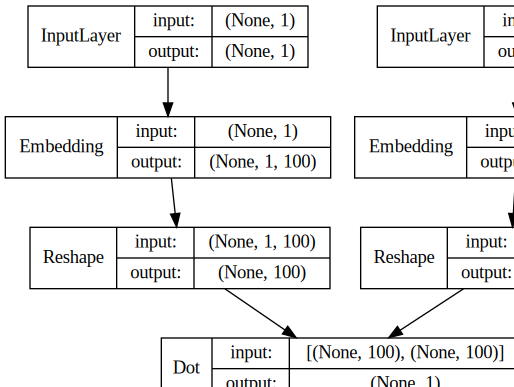

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes = True,
                 show_layer_names = False,
                 rankdir = 'TB').create(prog = 'dot', format = 'svg'))

### Train the model for 5 epochs

In [17]:
for epoch in range(1, 6):
  
  loss = 0
  for i, elem in enumerate(skip_grams):
    pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype = 'int32')
    pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype = 'int32')
    labels = np.array(elem[1], dtype = 'int32')
    X = [pair_first_elem, pair_second_elem]
    Y = labels
    if i % 10000 == 0:
      print('Processed {} (skip_first, skip_second, relevance) pairs'
            .format(i))
    loss += model.train_on_batch(X, Y)
    
  print('Epoch: ', epoch, 'Loss: ', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch:  1 Loss:  4520.97681911476
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch:  2 Loss:  3773.3150415457785
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch:  3 Loss:  3766.4978694614256
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch:  4 Loss:  3810.499009953346
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) 

### Get word embeddings

In [18]:
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)

pd.DataFrame(weights, index = id2word.values()).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
shall,-0.089814,-0.031943,0.028669,0.180987,0.006015,-0.020413,0.240868,-0.107821,0.033118,-0.388357,-0.160823,0.149137,0.110603,-0.011333,-0.071407,0.120764,0.105707,-0.066306,-0.174874,-0.058356,-0.121626,0.069407,0.045864,-0.080418,0.087310,-0.002998,-0.142583,-0.014497,0.004136,-0.122882,-0.029868,0.016469,-0.111060,0.130912,-0.071966,0.040328,-0.102258,-0.003076,-0.071368,-0.168693,...,0.036932,-0.022816,-0.041196,-0.031239,-0.057662,0.152945,0.042126,-0.053648,0.052000,0.082593,-0.078430,0.013522,-0.240267,-0.108156,-0.137275,-0.139127,0.378570,-0.008551,-0.062035,0.091176,0.091649,-0.062482,0.027322,-0.040036,-0.008651,-0.012527,0.028160,-0.125519,-0.000133,-0.035455,0.106783,-0.057236,0.076430,-0.107872,0.041425,-0.055094,0.089397,-0.208308,-0.034008,0.052317
unto,0.050347,-0.084752,-0.013146,-0.066068,-0.043184,0.063359,0.140660,0.053195,0.003263,-0.208571,-0.068948,0.151963,0.035001,-0.055712,-0.014948,0.091998,-0.009849,-0.125290,-0.129860,0.054994,0.027289,0.128610,-0.021320,-0.012649,0.107016,-0.019324,-0.076283,-0.051381,-0.184897,-0.116388,-0.138083,0.201055,-0.074464,0.011202,-0.096263,0.020652,-0.049908,0.002400,0.076293,-0.338883,...,-0.091330,-0.011145,0.031613,-0.081657,-0.127380,-0.046209,0.017970,0.040421,-0.041877,-0.002956,-0.012001,-0.034618,-0.027158,-0.002705,-0.128996,-0.274762,0.318641,-0.008631,0.026451,0.082938,0.089430,-0.092823,-0.006532,-0.062748,0.082162,-0.067331,-0.218910,-0.009760,0.085148,-0.012897,-0.121356,-0.176128,-0.011544,-0.191398,-0.053983,0.011147,0.252155,-0.240189,0.074116,0.044965
lord,0.052530,0.006610,-0.206408,-0.017114,0.039495,-0.045961,0.037598,-0.144169,0.054453,-0.273282,-0.164703,0.122058,0.093251,-0.082034,0.066696,0.040908,0.188386,-0.017691,-0.256448,-0.001639,-0.038536,0.064041,0.019009,-0.136133,0.068815,-0.043397,-0.092251,-0.121861,0.010059,-0.127283,-0.038790,0.021943,-0.304519,0.000815,-0.056225,0.093273,-0.068995,0.148711,0.036446,-0.104276,...,-0.044645,-0.045431,-0.033897,-0.052078,0.061242,-0.081368,0.201822,-0.138229,0.061677,0.081057,-0.107607,-0.058055,0.021582,0.027834,-0.075860,-0.054877,0.264815,-0.185424,-0.069564,0.124451,-0.007879,-0.020832,0.016603,-0.127513,0.078731,-0.030353,-0.201389,-0.017240,0.162449,-0.002706,0.323490,-0.071870,0.087644,-0.060108,-0.097883,-0.102004,-0.018924,-0.390115,0.011505,0.041300
thou,0.007796,-0.016812,-0.078018,-0.190711,-0.101397,0.029448,-0.018691,-0.071599,0.030829,-0.368099,-0.102236,0.166539,0.080339,-0.064812,-0.023697,0.102357,0.264047,-0.036091,-0.004077,-0.016048,-0.188201,0.062426,0.038115,0.087674,0.373873,0.012594,-0.042840,0.013509,-0.108373,-0.031871,-0.029111,0.108935,-0.166815,-0.019310,-0.087051,0.074763,-0.013106,0.117969,-0.055191,-0.286800,...,-0.034029,-0.041700,0.099024,-0.089595,-0.014826,-0.085663,0.042018,0.024029,0.071804,0.027120,-0.080338,-0.136071,-0.077098,-0.107729,-0.154899,0.026677,0.396940,-0.074370,-0.017067,0.040066,-0.014533,-0.006112,-0.007895,-0.260606,-0.028380,0.003937,-0.058250,0.045269,0.341620,0.065176,0.051244,-0.006526,-0.033875,-0.010685,0.044724,-0.073836,0.137937,0.042993,0.060241,0.030146
thy,-0.050704,0.002818,0.003111,0.003742,-0.001925,0.005199,0.024725,-0.084932,-0.014850,-0.227530,-0.133020,0.095556,0.034031,-0.016636,0.016822,0.016856,0.305964,-0.081356,-0.093262,-0.013205,-0.016899,0.005068,-0.017525,0.029869,0.278441,-0.058487,-0.100268,0.037359,0.017353,-0.107676,0.002655,0.049367,-0.234950,-0.056730,0.013448,0.045209,0.011057,0.015514,0.093014,-0.232546,...,-0.032399,-0.071458,-0.027371,0.009269,-0.220634,0.008876,-0.022366,-0.039278,-0.005055,0.121237,-0.041707,-0.051311,-0.006327,0.066233,-0.138193,-0.127178,0.436504,-0.108522,-0.068732,-0.066201,-0.070075,0.103794,0.140407,-0.107574,-0.004455,-0.086039,-0.087263,0.049973,

### Build a distance matrix to view the most similar words (contextually)

In [19]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in 
                               distance_matrix[word2id[search_term] - 1].argsort()[1:6] + 1]
                 for search_term in ['god', 'jesus', 'noah', 'egypt',
                                     'john', 'gospel', 'moses', 'famine']}

similar_words

(12424, 12424)


{'egypt': ['gods', 'houses', 'dwell', 'multitude', 'hosts'],
 'famine': ['fury', 'desolation', 'curse', 'shed', 'angels'],
 'god': ['wherefore', 'known', 'works', 'law', 'would'],
 'gospel': ['ask', 'teach', 'promise', 'true', 'saviour'],
 'jesus': ['christ', 'things', 'disciples', 'many', 'heard'],
 'john': ['church', 'ghost', 'scribes', 'pharisees', 'received'],
 'moses': ['aaron', 'congregation', 'commanded', 'sacrifice', 'princes'],
 'noah': ['eber', 'dam', 'yearned', 'smallest', 'meraioth']}

### Visualize word embeddings

Total words:  48 	 Word Embedding shapes:  (48, 100)


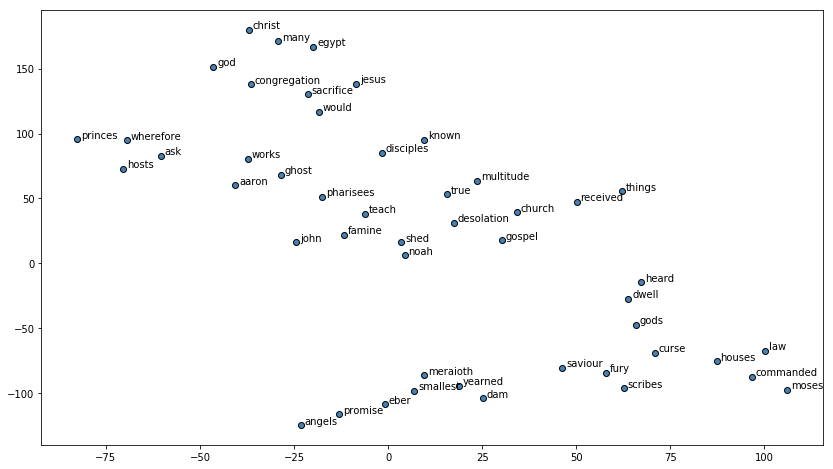

In [20]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])

print('Total words: ', len(words), '\t Word Embedding shapes: ',
      word_vectors.shape)


tsne = TSNE(n_components = 2, random_state = 0,
            n_iter = 10000, perplexity = 3)
np.set_printoptions(suppress = True)
T = tsne.fit_transform(word_vectors)
labels = words


plt.figure(figsize = (14, 8))
plt.scatter(T[:, 0], T[:, 1], 
            c = 'steelblue',
            edgecolors = 'k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy = (x + 1, y + 1),
               xytext = (0, 0), 
               textcoords = 'offset points')

## Leveraging gensim for building a word2vec model

In [21]:
from gensim.models import word2vec

## Tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) 
                    for document in norm_bible]

## Set values for various parameters
feature_size = 100      ## Word vector dimensionality
window_context = 30     ## Context window size
min_word_count = 1      ## Minimum word count
sample = 1e-3           ## Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus,
                              size = feature_size,
                              window = window_context,
                              min_count = min_word_count,
                              sample = sample, 
                              iter = 50)

## View similar words based on gensim's model
similar_words = {search_term: [item[0] for item in 
                               w2v_model.wv.most_similar([search_term], topn = 5)]
                 for search_term in ['god', 'jesus', 'noah', 'egypt',
                                     'john', 'gospel', 'moses', 'famine']}

similar_words

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'egypt': ['egyptians', 'pharaoh', 'bondage', 'rod', 'rid'],
 'famine': ['pestilence', 'peril', 'blasting', 'mildew', 'caterpiller'],
 'god': ['lord', 'worldly', 'ungodliness', 'promised', 'sworn'],
 'gospel': ['christ', 'repentance', 'preach', 'faith', 'godly'],
 'jesus': ['peter', 'messias', 'immediately', 'james', 'synagogue'],
 'john': ['baptist', 'james', 'devine', 'baptize', 'baptism'],
 'moses': ['congregation', 'aaron', 'children', 'elisheba', 'joshua'],
 'noah': ['japheth', 'shem', 'ham', 'hoglah', 'noe']}

### Visualizing word embeddings

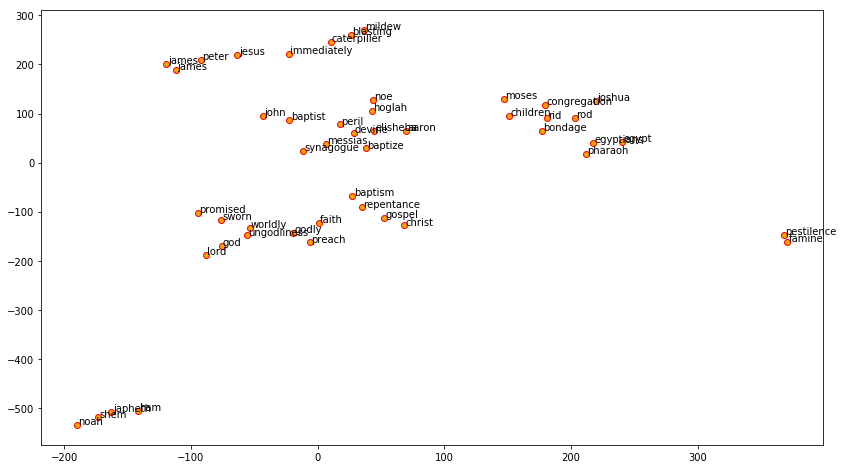

In [22]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components = 2,
            random_state = 0,
            n_iter = 10000,
            perplexity = 2)
np.set_printoptions(suppress = True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize = (14, 8))
plt.scatter(T[:, 0], T[:, 1],
            c = 'orange',
            edgecolors = 'r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy = (x + 1, y + 1), xytext = (0, 0),
               textcoords = 'offset points')

## Applying the word2vec model on our sample corpus

In [0]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document)
                    for document in norm_corpus]

## Set values for various parameters
feature_size = 10      ## Word vector dimensionality
window_context = 10    ## Context window size
min_word_count = 1     ## Minimum word count
sample = 1e-3          ## Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus,
                              size = feature_size,
                              window = window_context,
                              min_count = min_word_count,
                              sample = sample, iter = 100)

### Visualize word embeddings

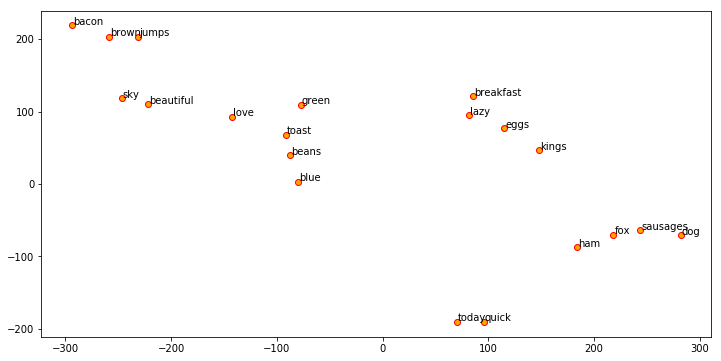

In [24]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components = 2,
            random_state = 0,
            n_iter = 5000,
            perplexity = 2)
np.set_printoptions(suppress = True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize = (12, 6))
plt.scatter(T[:, 0], T[:, 1], 
            c = 'orange',
            edgecolors = 'r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy = (x + 1, y + 1), xytext = (0, 0),
               textcoords = 'offset points')

### Sample word embedding

In [25]:
w2v_model.wv['sky']

array([ 0.03433074,  0.03269683, -0.03608935,  0.01004518,  0.02518425,
       -0.01380523,  0.02346183, -0.04413415, -0.03186401, -0.03603324],
      dtype=float32)

### Build framework for getting document level embeddings

In [0]:
def average_word_vectors(words, model, vocabulary,
                         num_features):
  
  feature_vector = np.zeros((num_features, ), dtype = "float64")
  nwords = 0.
  
  for word in words:
    if word in vocabulary:
      nwords = nwords + 1.
      feature_vector = np.add(feature_vector, model[word])
  
  if nwords:
    feature_vector = np.divide(feature_vector, nwords)
  
  return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
  vocabulary = set(model.wv.index2word)
  features = [average_word_vectors(tokenized_sentence,
                                   model, vocabulary, num_features)
              for tokenized_sentence in corpus]
  
  return np.array(features)

In [27]:
w2v_feature_array = averaged_word_vectorizer(
    corpus = tokenized_corpus,
    model = w2v_model,
    num_features = feature_size
)

pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


,0,1,2,3,4,5,6,7,8,9
0,0.001760,0.032937,-0.016562,0.009528,0.001557,-0.005913,0.021217,-0.013899,-0.016701,-0.031905
1,0.007501,0.024224,-0.006336,0.017033,0.012564,-0.011854,0.025693,-0.001774,-0.003637,-0.021645
2,0.003332,0.006527,0.005486,-0.009746,0.004814,-0.002669,-0.004478,0.003288,0.002836,-0.016141
3,-0.010652,-0.001324,0.024650,0.013668,-0.008124,-0.009520,0.000115,0.003078,0.012497,-0.000986
4,0.007037,-0.003922,0.021389,0.007324,0.002160,-0.011370,0.014953,0.006956,0.020435,0.004171
5,0.001812,0.009182,0.002917,-0.005546,-0.011639,0.003245,0.002010,-0.002955,0.007162,-0.013470
6,0.001376,0.032282,-0.022041,-0.001847,0.004163,0.000091,0.025940,-0.024507,-0.016009,-0.017757
7,0.002627,0.002442,0.002037,-0.008381,-0.003946,-0.005022,-0.001128,-0.001963,0.011037,-0.011915


### Clustering with word embeddings

In [28]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, 
                              columns = ['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis = 1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,2


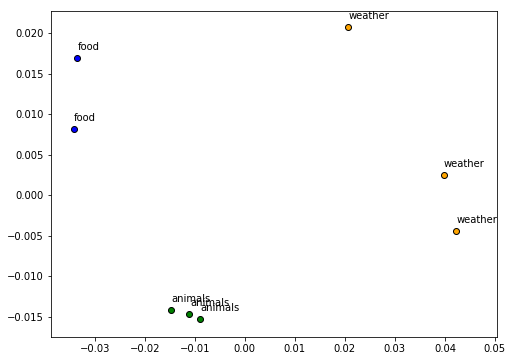

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize = (8, 6))

for i in range(len(labels)):
  label = labels[i]
  color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
  annotation_label = categories[i]
  x, y = pcs[i]
  plt.scatter(x, y, c = color, edgecolors = 'k')
  plt.annotate(annotation_label,
               xy = (x + 1e-4, y + 1e-3),
               xytext = (0, 0),
               textcoords = 'offset points')

# GloVe Embeddings with spaCy

In [30]:
!pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.1.8)


In [34]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_vectors_web_lg-2.0.0/en_vectors_web_lg-2.0.0.tar.gz

     |████████████████████████████████| 661.8MB 24kB/s 
  Created wheel for en-vectors-web-lg: filename=en_vectors_web_lg-2.0.0-cp36-none-any.whl size=663442344 sha256=652461018c480e0947cebfe8e62a59009693955c03b6c9a2c1673b4c39afde75
  Stored in directory: /root/.cache/pip/wheels/2c/55/44/2ad57e8927662fc7b3e7c9f35be3e4feda40c1be5d4def2a67
Successfully built en-vectors-web-lg


In [50]:
import spacy.cli
spacy.cli.download("en_vectors_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')


In [51]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors: ', total_vectors)

Total word vectors:  1070971


## Visualize GloVe word embeddings

In [52]:
unique_words = list(set([word for sublist in [doc.split()
                                              for doc in norm_corpus]
                         for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index = unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
beans,-0.423290,-0.264500,0.200870,0.082187,0.066944,1.027600,-0.989140,-0.259950,0.145960,0.766450,-0.581010,0.317560,-0.043719,-0.847330,0.188070,-0.716880,0.009522,1.124100,0.437220,0.371400,-0.208100,-0.380830,-0.282530,0.159310,-0.096079,-0.959680,-0.222080,0.299910,0.163690,-0.710410,0.242250,-0.072045,0.802380,-0.477040,-0.313830,0.332220,0.277570,0.260040,0.278750,0.600180,...,-0.157950,-0.233430,0.009833,0.106710,-0.324040,0.290390,-0.099283,-0.294040,-0.564550,0.230860,0.647260,-0.244820,0.223060,-0.353680,-0.633440,0.286330,-0.448500,0.002610,0.687900,0.707310,0.353040,-0.451420,0.177150,-0.599130,0.276450,0.776900,0.776190,0.449290,0.172610,-0.184870,0.048760,0.351680,-0.786260,-0.368790,-0.528640,0.287650,-0.273120,-1.114000,0.064322,0.223620
blue,0.129450,0.036518,0.032298,-0.060034,0.399840,-0.103020,-0.507880,0.076630,-0.422920,0.815730,-0.182540,-0.072278,-0.358110,-0.428660,0.108800,0.151030,0.240360,2.115100,-0.116390,-1.058300,-0.053679,-0.340660,-0.387930,0.220610,-0.345300,-0.294830,-0.377170,0.040785,0.155960,0.378200,-0.230140,0.106140,-0.083818,-0.121110,-0.498090,-0.311230,0.168420,0.005281,-0.281660,-0.335470,...,0.158920,0.486020,-0.087139,0.601080,-0.000770,-0.082692,-0.120790,0.113970,-0.492130,-0.134840,-0.493600,0.351470,-0.019813,-0.075597,0.369570,-0.309500,-0.218600,0.335340,0.106540,-0.123870,-0.140150,-0.312630,-0.524710,-0.285340,-0.277620,0.080487,0.060031,0.539010,0.554740,-0.147810,-0.501280,0.169010,0.548250,-0.319380,-0.072887,0.382950,0.237410,0.052289,0.182060,0.412640
lazy,-0.353320,-0.299710,-0.176230,-0.321940,-0.385640,0.586110,0.411160,-0.418680,0.073093,1.486500,0.178510,-0.364790,-0.318890,-0.186660,-0.176970,-0.185470,-0.287790,0.579630,0.413430,-0.142170,-0.122250,0.093341,-0.117550,-0.436210,0.416610,-0.172810,0.080734,-0.534250,0.790970,-0.175410,-0.503800,0.092905,0.000162,-0.636440,0.064689,0.262830,0.266300,0.183250,-0.397460,0.109490,...,-0.185390,0.121400,-0.077576,-0.188900,0.394630,-0.383130,-0.288160,-0.359380,0.642020,0.084683,-0.288520,-0.443680,-0.141780,-0.207710,0.006349,-0.368950,-0.082058,-0.195290,-0.067179,0.001303,0.468360,-0.175710,0.198760,0.467780,0.593930,-0.335560,-0.072169,-0.369840,0.114630,0.430670,0.402310,-0.038554,-0.288670,-0.244130,0.460990,0.514170,0.136260,0.344190,-0.845300,-0.077383
bacon,-0.430730,-0.016025,0.484620,0.101390,-0.299200,0.761820,-0.353130,-0.325290,0.156730,0.873210,-0.078280,0.277670,-0.524210,0.103800,-0.018345,-0.397500,0.230810,0.940140,0.275650,0.314490,0.157910,0.219310,-0.328710,-0.187760,-0.209180,-0.528110,-0.425460,0.020278,0.124110,-0.553420,-0.566570,0.768710,0.329540,-0.153310,0.631360,0.108580,-0.126160,0.102500,0.291810,1.129400,...,0.011195,-0.129620,-0.518830,0.015317,0.249340,0.594640,-0.209520,-0.364450,-0.853380,-0.196230,0.425870,-0.343410,0.622890,0.374680,-0.768440,0.632930,0.026989,-0.281060,-0.010866,0.182310,0.437670,-0.278490,0.109020,-0.177370,0.025408,0.480750,0.586230,0.424540,-0.247770,0.165690,0.304240,0.413440,-0.540730,-0.035930,-0.429450,-0.246590,0.161490,-1.065400,-0.244940,0.269540
jumps,-0.334840,0.215990,-0.350440,-0.260020,0.411070,0.154010,-0.386110,0.206380,0.386700,1.460500,0.355940,-0.057770,-0.310030,0.533790,-0.016381,0.366800,0.360580,0.362340,-0.101930,-0.365060,-0.546650,0.563370,0.229860,-0.757940,0.320240,0.132530,0.343050,-0.240840,0.044138,-0.535110,-0.257930,0.346190,-0.071962,-0.213440,0.332550,-0.404350,0.107330,-0.027624,0.289630,-0.225150,...,0.134910,0.343390,0.048773,-0.517680,0.212040,0.051897,0.142010,0.225710,0.352020,0.398190,-0.202120,-0.097922,-0.024712,-0.100950,0.000120,-0.443560,0.097503,-0.128980,0.123670,-0.291170,-0.302130,-0.337530,-0.372290,0.201640,0.419570,0.020038,-0.171160,0

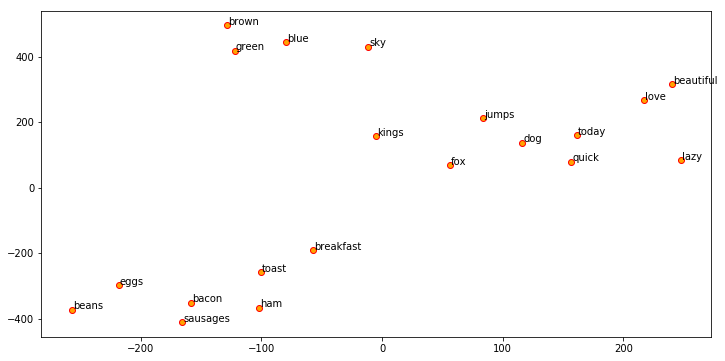

In [53]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2,
            random_state = 0,
            n_iter = 5000,
            perplexity = 3)
np.set_printoptions(suppress = True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize = (12, 6))
plt.scatter(T[:, 0], T[:, 1], 
            c = 'orange',
            edgecolors = 'r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, 
               xy = (x + 1, y + 1),
               xytext = (0, 0),
               textcoords = 'offset points')

## Cluster documents with Glove Embeddings

In [55]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector 
                              for doc in norm_corpus])

km = KMeans(n_clusters = 3, random_state = 0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels,
                              columns = ['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis = 1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


# Leveraging gensim for building a FastText model

In [0]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document)
                    for document in norm_bible]

## Set values for various parameters
feature_size = 100      ## Word vector dimensionality
window_context = 50     ## Context window size
min_word_count = 5      ## Minimum word count
sample = 1e-3           ## Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, 
                    size = feature_size,
                    window = window_context,
                    min_count = min_word_count,
                    sample = sample,
                    sg = 1, iter = 50)

In [58]:
## View similar words based on gensim's model

similar_words = {search_term: [item[0] for item in
                               ft_model.wv.most_similar([search_term], topn = 5)]
                 for search_term in ['god', 'jesus', 'noah', 'egypt',
                                     'john', 'gospel', 'moses', 'famine']}

similar_words

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'egypt': ['land', 'egyptians', 'pharaoh', 'israel', 'pathros'],
 'famine': ['pestilence', 'dearth', 'mildew', 'blasting', 'sword'],
 'god': ['lord', 'christ', 'unto', 'therefore', 'jesus'],
 'gospel': ['preached', 'preach', 'christ', 'preaching', 'grace'],
 'jesus': ['christ', 'god', 'disciples', 'grace', 'faith'],
 'john': ['baptist', 'peter', 'baptize', 'philip', 'baptism'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'israel'],
 'noah': ['methuselah', 'milcah', 'flood', 'shem', 'creepeth']}

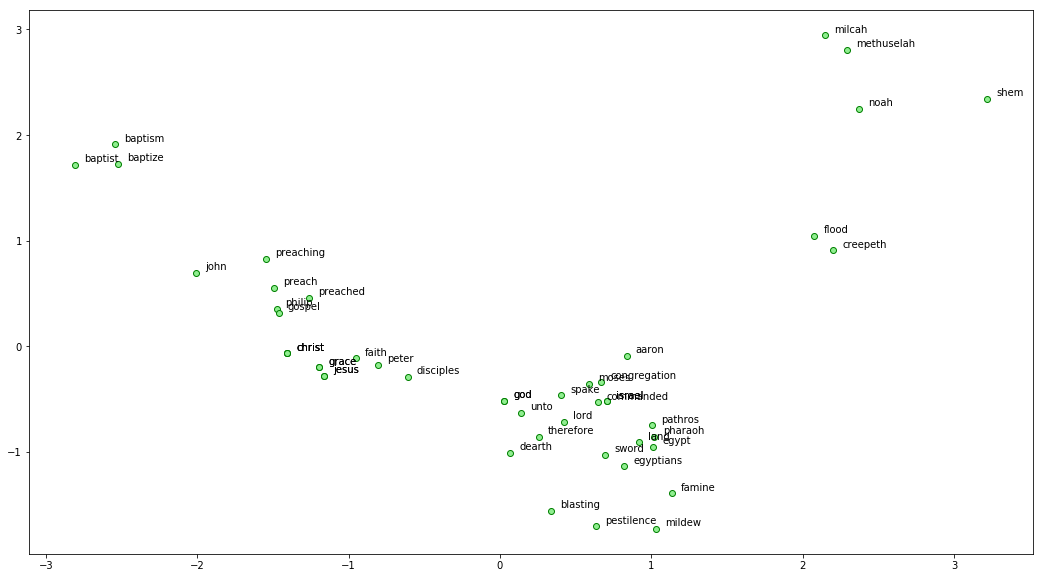

In [59]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components = 2)
np.set_printoptions(suppress = True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize = (18, 10))
plt.scatter(P[:, 0], P[:, 1],
            c = 'lightgreen',
            edgecolors = 'g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
  plt.annotate(label, 
               xy = (x + 0.06, y + 0.03),
               xytext = (0, 0),
               textcoords = 'offset points')

In [60]:
ft_model.wv['jesus']

array([-0.389242  , -0.08275358,  0.17308539,  0.34924442,  0.2988324 ,
        0.30380806, -0.34346735, -0.33063325, -0.15754955,  0.24643418,
       -0.18081172, -0.23810944,  0.10132339, -0.01101554,  0.19016133,
        0.2264719 ,  0.41897497, -0.40517572, -0.05782242,  0.04022807,
       -0.18338816,  0.48879975, -0.03806143,  0.14891672,  0.40493795,
       -0.32966843,  0.09704027, -0.10099898,  0.03010893,  0.09429307,
        0.04405629, -0.5566746 , -0.17031887,  0.14110497,  0.49346933,
       -0.07435973, -0.15831323, -0.3150211 , -0.15890439,  0.34876627,
       -0.16806813,  0.12749371, -0.175906  , -0.02854225,  0.13192362,
       -0.5806539 , -0.01586487,  0.65247905, -0.19546357,  0.07279895,
       -0.18244447, -0.25118145, -0.01668706, -0.24954104,  0.12362697,
       -0.09648182, -0.08344991,  0.34976292,  0.1382667 , -0.00271776,
        0.3104372 , -0.09227111, -0.06336328,  0.07405642,  0.29674187,
        0.19784339,  0.0508886 , -0.14675097,  0.04431519,  0.23

In [61]:
print(ft_model.wv.similarity(w1 = 'god', w2 = 'satan'))

print(ft_model.wv.similarity(w1 = 'god', w2 = 'jesus'))

0.32278508
0.6763732


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [62]:
st1 = "god jesus satan john"
print('Odd one out for [', st1, ']: ',
      ft_model.wv.doesnt_match(st1.split()))

st2 = "john peter james judas"
print('Odd one out for [', st2, ']: ',
      ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]:  satan
Odd one out for [ john peter james judas ]:  judas


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
